### Todos:
### 1. preprocess the data to make it suitable for glove embeding:
### a. remove ' from words( don't -> dont)
### b. convert all letters to lowercase ( Hoping -> hoping)
### 2. find the frequency of each emoji to see if the dataset is balanced and balance the dataset(important)

In [0]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import pandas

In [0]:
def get_data():
    header = ['tweet','label']
    data_set = pandas.read_csv('augment_spelling.txt',delimiter='\t',names = header)
    return data_set

def split_tweet(tweet):
    return tweet.split()    


In [0]:
data_set = get_data()

In [0]:
glove = torchtext.vocab.GloVe(name="twitter.27B",dim=50)

# inser padding character into glove embedding, we overwrite the first element and that's okay
# because we don't use the first element in our vocab
glove.vectors[0] = torch.tensor(np.zeros(50))

In [6]:
len(data_set)

11379

In [0]:
def data_set_to_glove_index(glove_dict):
    tweets_ints, encoded_labels = [],[]
    for i in range(len(data_set)):
        tweet = data_set['tweet'][i]
        label = data_set['label'][i]
        if(type(tweet) != str):
            continue
        idxs = [glove_dict.stoi[w]        # lookup the index of word
            for w in tweet.split()
            if w in glove_dict.stoi] # keep words that has an embedding
        if not idxs: # ignore tweets without any word with an embedding
            continue
        tweets_ints.append(idxs)
        encoded_labels.append(label)
    return tweets_ints, encoded_labels

In [0]:
tweets_ints, encoded_labels = data_set_to_glove_index(glove)

In [9]:
from collections import Counter
# outlier review stats
tweets_lens = Counter([len(x) for x in tweets_ints])
print("Zero-length tweets: {}".format(tweets_lens[0]))
print("Maximum tweet length: {}".format(max(tweets_lens)))

Zero-length tweets: 0
Maximum tweet length: 38


In [0]:
def pad_features(tweets_ints, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's 
        or truncated to the input seq_length.
    '''
    
    # getting the correct rows x cols shape
    features = np.zeros((len(tweets_ints), seq_length), dtype=int)

    # for each review, I grab that review and 
    for i, row in enumerate(tweets_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]
    
    return features

In [0]:
seq_length = max(tweets_lens)

features = pad_features(tweets_ints, seq_length=seq_length)
encoded_labels = np.array(encoded_labels)

### Train, Validation, Test Split

In [0]:
from sklearn.utils import shuffle
features, encoded_labels = shuffle(features, encoded_labels)

In [13]:
split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(features)*split_frac)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(9102, 38) 
Validation set: 	(1138, 38) 
Test set: 		(1138, 38)


### DataLoader and Batching

In [0]:
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 50

# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size,drop_last=True)

In [15]:
len(train_loader)

182

### Building the model

In [0]:
class TweetLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetLSTM, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state and cell state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the LSTM
        out, _ = self.rnn(x, (h0, c0))
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out
num_classes = 6
model = TweetLSTM(input_size=50, hidden_size=50, num_classes=num_classes)

In [17]:
def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for tweets, labels in data_loader:
        output = model(tweets)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return float(correct) / float(total)

get_accuracy(model, test_loader)


0.04454545454545455

In [0]:
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    counter = 0
    for epoch in range(num_epochs):
        for tweets, labels in train:
            counter += 1
            optimizer.zero_grad()
            pred = model(tweets)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            if counter % 100 == 0:
                print("Step %d of Epoch: %d; Loss %f " % ( counter/100 ,epoch+1,float(loss)))
                
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        print("Final Result for Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
        
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Step 1 of Epoch: 1; Loss 1.071759 
Final Result for Epoch 1; Loss 1.257612; Train Acc 0.575165; Val Acc 0.590000
Step 2 of Epoch: 2; Loss 1.203213 
Step 3 of Epoch: 2; Loss 0.970145 
Final Result for Epoch 2; Loss 0.981377; Train Acc 0.590879; Val Acc 0.599091
Step 4 of Epoch: 3; Loss 1.041533 
Step 5 of Epoch: 3; Loss 1.180924 
Final Result for Epoch 3; Loss 1.058670; Train Acc 0.596484; Val Acc 0.611818
Step 6 of Epoch: 4; Loss 1.262352 
Step 7 of Epoch: 4; Loss 1.175750 
Final Result for Epoch 4; Loss 1.223465; Train Acc 0.598791; Val Acc 0.605455
Step 8 of Epoch: 5; Loss 0.988472 
Step 9 of Epoch: 5; Loss 0.730529 
Final Result for Epoch 5; Loss 1.001997; Train Acc 0.600110; Val Acc 0.610909
Step 10 of Epoch: 6; Loss 1.077517 
Final Result for Epoch 6; Loss 1.155995; Train Acc 0.608791; Val Acc 0.612727
Step 11 of Epoch: 7; Loss 1.031526 
Step 12 of Epoch: 7; Loss 1.019217 
Final Result for Epoch 7; Loss 0.839932; Train Acc 0.610769; Val Acc 0.611818
Step 13 of Epoch: 8; Loss 1.296

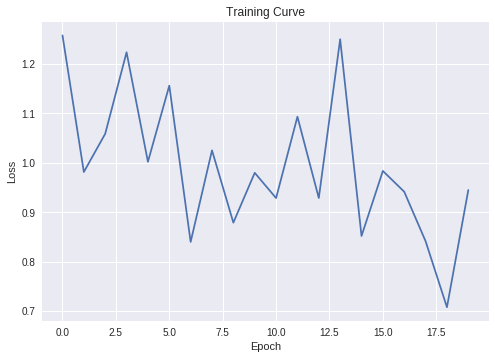

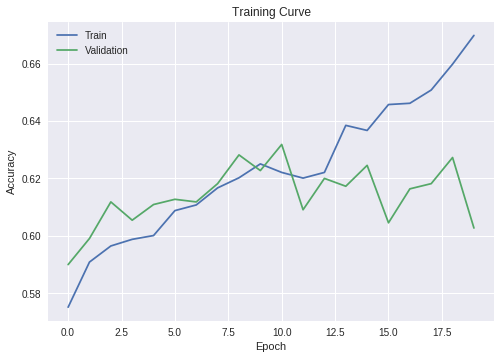

0.5809090909090909

In [19]:
model_lstm = TweetLSTM(input_size=50, hidden_size=50, num_classes=num_classes)
train_rnn_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=1e-3)
get_accuracy(model, test_loader)

### Saving the model

In [0]:
#torch.save(model.state_dict(), 'checkpoint.pth')

### Loading the model

In [0]:
#state_dict = torch.load('checkpoint.pth')

In [0]:
#model.load_state_dict(state_dict)

### Inference

In [0]:
# Tweet Test
happy_tweet = 'Im happy'
sad_tweet = 'Im sad'
angry = 'Im angry'
surprised_tweet = 'Im surprised'
disgusted_tweet = 'Im disgusted'
afraid_tweet = 'Im afraid'

In [0]:
def tweet_to_glove_index(tweet,glove_dict):
    tweets_ints = []
    tweet = tweet.lower()
    idxs = [glove_dict.stoi[w]        # lookup the index of word
            for w in tweet.split()
            if w in glove_dict.stoi] # keep words that has an embedding
    tweets_ints.append(idxs)
    return tweets_ints

In [0]:
int_to_emotion = {0:'Happy', 1:'Sad' , 2:'Angry', 3:'Surprised', 4:'Disgusted', 5:'Afraid'}

def predict(model, test_tweet, sequence_length=max(tweets_lens)):
    
    
    # tokenize tweet
    test_ints = tweet_to_glove_index(test_tweet,glove)
    
    # pad tokenized sequence
    seq_length=sequence_length
    features = pad_features(test_ints, seq_length)
    
    # convert to tensor to pass into your model
    feature_tensor = torch.from_numpy(features)
    
    batch_size = feature_tensor.size(0)
    
    
    # get the output from the model
    output = model(feature_tensor)
    
    # convert output probabilities to predicted class (0 or 1)
    output_prob = nn.functional.softmax(output,dim=1)
    top_n_pred = output_prob.topk(3,dim=1) ## top 3 preds
    top_n_pred_prob, top_n_pred_index = top_n_pred[0].detach().numpy()[0], top_n_pred[1].detach().numpy()[0]
    print(test_tweet)
    print('Prediction:')
    for prob,index in zip(top_n_pred_prob,top_n_pred_index):
        print(int_to_emotion[index] , 'with' , str(int(prob*100))+"%", 'confidence')
    print('---------------')

In [26]:
predict(model,happy_tweet)
predict(model,sad_tweet)
predict(model,angry)
predict(model,surprised_tweet)
predict(model,disgusted_tweet)
predict(model,afraid_tweet)

Im happy
Prediction:
Sad with 44% confidence
Happy with 35% confidence
Afraid with 5% confidence
---------------
Im sad
Prediction:
Sad with 77% confidence
Happy with 5% confidence
Afraid with 5% confidence
---------------
Im angry
Prediction:
Sad with 33% confidence
Happy with 21% confidence
Surprised with 16% confidence
---------------
Im surprised
Prediction:
Happy with 29% confidence
Sad with 29% confidence
Surprised with 12% confidence
---------------
Im disgusted
Prediction:
Sad with 42% confidence
Happy with 12% confidence
Surprised with 12% confidence
---------------
Im afraid
Prediction:
Sad with 35% confidence
Surprised with 17% confidence
Happy with 16% confidence
---------------


In [0]:
tweets = ['he said he will be there and he showed up','he said he will be there but he did not show up', 'he said he will be there and he showed up with his friends',
          'I lose', 'I have lost', 'I won', 'Live long', 'I am the best', 'I hate losing', 'I dont hate you', 'I do not hate you']

In [28]:
for tweet in tweets:
    predict(model, tweet)

he said he will be there and he showed up
Prediction:
Happy with 50% confidence
Sad with 14% confidence
Afraid with 13% confidence
---------------
he said he will be there but he did not show up
Prediction:
Happy with 44% confidence
Sad with 17% confidence
Afraid with 13% confidence
---------------
he said he will be there and he showed up with his friends
Prediction:
Sad with 30% confidence
Happy with 28% confidence
Afraid with 17% confidence
---------------
I lose
Prediction:
Happy with 54% confidence
Sad with 30% confidence
Angry with 5% confidence
---------------
I have lost
Prediction:
Sad with 45% confidence
Happy with 43% confidence
Disgusted with 3% confidence
---------------
I won
Prediction:
Happy with 83% confidence
Sad with 10% confidence
Angry with 2% confidence
---------------
Live long
Prediction:
Happy with 74% confidence
Sad with 12% confidence
Surprised with 3% confidence
---------------
I am the best
Prediction:
Happy with 67% confidence
Sad with 18% confidence
Angry

In [29]:
tweets = ['You are so crazy',
          'You make me feel so cool',
          'I hate you',
          'I HATE YOU',
          'you ruined my apetite',
          'that food was terrible']

for tweet in tweets:
    predict(model, tweet)

You are so crazy
Prediction:
Happy with 87% confidence
Sad with 8% confidence
Surprised with 0% confidence
---------------
You make me feel so cool
Prediction:
Happy with 84% confidence
Sad with 12% confidence
Angry with 1% confidence
---------------
I hate you
Prediction:
Sad with 37% confidence
Happy with 24% confidence
Disgusted with 15% confidence
---------------
I HATE YOU
Prediction:
Sad with 37% confidence
Happy with 24% confidence
Disgusted with 15% confidence
---------------
you ruined my apetite
Prediction:
Happy with 55% confidence
Sad with 29% confidence
Disgusted with 7% confidence
---------------
that food was terrible
Prediction:
Sad with 52% confidence
Happy with 22% confidence
Disgusted with 12% confidence
---------------
